In [323]:
using DataFrames
using CSV
using JSON
using HTTP
using Dates
using Gadfly
import Cairo, Fontconfig

In [244]:
ENV["COLUMNS"] = 1000;

In [13]:
function reinterpret1d(input)
    return Float64.(input)
end

function reinterpret2d(input)
    n, m = length(input), length(input[1])
    arr = Array{Float64,2}(undef, n, m)
    for i in 1:n
        arr[i,:] = Float64.(input[i])
    end
    return arr
end;

function reinterpret3d(input)
    n, m, l = length(input), length(input[1]), length(input[1][1])
    arr = Array{Float64,3}(undef, n, m, l)
    for i in 1:n, j in 1:m
        arr[i,j,:] = Float64.(input[i][j])
    end
    return arr
end;

In [227]:
request_data = Dict(
    :alloclevel => "hospital",
    :region_type => "state",
    :region_id => "FL",
    :hospitals => String[],
    :scenario => "moderate",
    :patient_type => "icu",
    :objective => "minoverflow",
    :integer => "false",
    :transferbudget => "1000",
    :utilization => "1.0",
    :covid_capacity_proportion => "0.5",
    :dist_threshold => "600",
    :uncertaintylevel => "default",
    :los => "default_dist",
    :start_date => "2020-12-15",
    :end_date => "2021-01-15",
    :smoothness => "false",
    :verbose => "true",
);

In [228]:
# url = "https://covid-hospital-operations.com/api/patients";
url = "http://localhost:8000/api/patients";

In [229]:
r_time = @elapsed r = HTTP.request("POST", url, ["Content-Type" => "application/json"], JSON.json(request_data))
response = String(r.body)
rawdata = JSON.parse(response)

Dict{String,Any} with 10 entries:
  "admitted"       => Any[Any[0.881633, 0.887755, 0.893878, 0.9, 0.936735, 0.97…
  "summary"        => Dict{String,Any}("total_received"=>Any[0.0, 2.57858, 0.0,…
  "full_results"   => Dict{String,Any}("active_patients"=>Any[2.02449, 2.51678,…
  "sent"           => Any[Any[Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, …
  "active_null"    => Any[Any[2.02449, 2.51678, 2.93536, 3.29021, 3.62266, 3.93…
  "active"         => Any[Any[2.02449, 2.51678, 2.93536, 3.29021, 3.62266, 3.93…
  "beds"           => Any[4.5, 0.5, 4.0, 23.0, 12.0, 14.5, 7.5, 4.0, 7.0, 5.0  …
  "config"         => Dict{String,Any}("dates"=>Any["2020-12-15", "2020-12-16",…
  "total_patients" => 10663.8
  "capacity"       => Any[Any[4.5], Any[0.5], Any[4.0], Any[23.0], Any[12.0], A…

In [230]:
# r = HTTP.get("https://covid-hospital-operations.com/results-static/latest_moderate_icu_state_FL.json")
# response = String(r.body)
# rawdata = JSON.parse(response)

In [254]:
data = (
    region = rawdata["config"]["region"]["region_name"],
    start_date = Date(rawdata["config"]["start_date"]),
    end_date = Date(rawdata["config"]["end_date"]),
    hospital_names = string.(rawdata["config"]["node_names"]),
    hospital_ids = [h["hospital_id"] for h in rawdata["config"]["nodes_meta"]],
    admitted = reinterpret2d(rawdata["admitted"]),
    capacity = reinterpret1d(rawdata["beds"]),
    active = reinterpret2d(rawdata["active"]),
    active_null = reinterpret2d(rawdata["active_null"]),
    sent = reinterpret3d(rawdata["sent"]),
    total_patients = rawdata["total_patients"],
);

In [255]:
rnd(x) = round(x, digits=2);
pct(x) = string(round(x*100, digits=2)) * "%";

In [256]:
println("Region: ", data.region)
println("Number of hospitals: ", length(data.hospital_names))
println("Number of days: ", size(data.admitted, 2))
println("Date range: ", data.start_date, " to ", data.end_date)
println("Server response time: ", rnd(r_time), "s")
println("Number of transfers: ", rnd(sum(data.sent)))
println("Total patients: ", rnd(data.total_patients))
println("Percent of patients transferred: ", pct(sum(data.sent)/data.total_patients))
println("Total capacity: ", rnd(sum(data.capacity)))
println("Max system occupancy: ", rnd(maximum(sum(data.active_null, dims=1))))
println("Number of hospitals with overflow (no transfers): ", count(maximum(data.active_null, dims=2) - data.capacity .> 1e-5))
println("Number of hospitals with overflow (with transfers): ", count(maximum(data.active, dims=2) - data.capacity .> 1e-5))
println("Overflow (no transfers): ", rnd(sum(max.(data.active_null .- data.capacity, 0))))
println("Overflow (with transfers): ", rnd(sum(max.(data.active .- data.capacity, 0))))
println("Beds required (no transfers): ", rnd(sum(max.(maximum(data.active_null, dims=2) - data.capacity, 0))))
println("Beds required (with transfers): ", rnd(sum(max.(maximum(data.active, dims=2) - data.capacity, 0))))

Region: Florida
Number of hospitals: 205
Number of days: 32
Date range: 2020-12-15 to 2021-01-15
Server response time: 192.59s
Number of transfers: 670.48
Total patients: 10663.8
Percent of patients transferred: 6.29%
Total capacity: 3067.0
Max system occupancy: 1944.52
Number of hospitals with overflow (no transfers): 64
Number of hospitals with overflow (with transfers): 4
Overflow (no transfers): 2918.32
Overflow (with transfers): 5.92
Beds required (no transfers): 182.92
Beds required (with transfers): 3.48


In [298]:
metrics_summary = DataFrame([
    ("Region", data.region),
    ("Number of hospitals", length(data.hospital_names)),
    ("Number of days", size(data.admitted, 2)),
    ("Start date", data.start_date),
    ("End date", data.end_date),
    ("Number of transfers", rnd(sum(data.sent))),
    ("Total patients", rnd(data.total_patients)),
    ("Percent of patients transferred", pct(sum(data.sent)/data.total_patients)),
    ("Total capacity", rnd(sum(data.capacity))),
    ("Max system occupancy", rnd(maximum(sum(data.active_null, dims=1)))),
    ("Number of hospitals with overflow (no transfers)", count(maximum(data.active_null, dims=2) - data.capacity .> 1e-5)),
    ("Number of hospitals with overflow (with transfers)", count(maximum(data.active, dims=2) - data.capacity .> 1e-5)),
    ("Overflow (no transfers)", rnd(sum(max.(data.active_null .- data.capacity, 0)))),
    ("Overflow (with transfers)", rnd(sum(max.(data.active .- data.capacity, 0)))),
    ("Beds required (no transfers)", rnd(sum(max.(maximum(data.active_null, dims=2) - data.capacity, 0)))),
    ("Beds required (with transfers)", rnd(sum(max.(maximum(data.active, dims=2) - data.capacity, 0)))),
])
rename!(metrics_summary, :1 => "Metric", :2 => "Value")

,Metric,Value
,String,Any
1,Region,Florida
2,Number of hospitals,205
3,Number of days,32
4,Start date,2020-12-15
5,End date,2021-01-15
6,Number of transfers,670.48
7,Total patients,10663.8
8,Percent of patients transferred,6.29%
9,Total capacity,3067.0


In [286]:
metadata = DataFrame(CSV.File("../data/hhs_hospital_meta.csv"))
filter!(h -> h.state_abbrev == "FL", metadata);

In [289]:
hid_to_system = Dict(row.hospital_id => row.system_name for row in eachrow(metadata));
hid_to_city = Dict(row.hospital_id => row.city for row in eachrow(metadata));
hid_to_hrr = Dict(row.hospital_id => row.hrr_name for row in eachrow(metadata));
hid_to_hsa = Dict(row.hospital_id => row.hsa_name for row in eachrow(metadata));

In [290]:
metrics_byhospital = DataFrame([
    (
        hospital_name = data.hospital_names[i],
        hospital_id = data.hospital_ids[i],
        system_name = hid_to_system[data.hospital_ids[i]],
        city = hid_to_city[data.hospital_ids[i]],
        hrr = hid_to_hrr[data.hospital_ids[i]],
        hsa = hid_to_hsa[data.hospital_ids[i]],
        capacity = data.capacity[i],
        admissions = sum(data.admitted[i,:]),
        transfers_out = sum(data.sent[i,:,:]),
        transfers_in = sum(data.sent[:,i,:]),
        overflow_wtfr = round(sum(max.(data.active[i,:] .- data.capacity[i], 0)), digits=3),
        overflow_notfr = round(sum(max.(data.active_null[i,:] .- data.capacity[i], 0)), digits=3),
        maxload_wtfr = maximum(data.active[i,:] ./ data.capacity[i]),
        maxload_notfr = maximum(data.active_null[i,:] ./ data.capacity[i]),
        requiredbeds_wtfr = round(maximum(max.(data.active[i,:] .- data.capacity[i], 0)), digits=3),
        requiredbeds_notfr = round(maximum(max.(data.active_null[i,:] .- data.capacity[i], 0)), digits=3),
    )
    for i in 1:length(data.hospital_ids)
])

,hospital_name,hospital_id,system_name,city,hrr,hsa,capacity,admissions,transfers_out,transfers_in,overflow_wtfr,overflow_notfr,maxload_wtfr,maxload_notfr,requiredbeds_wtfr,requiredbeds_notfr
,String,String,String?,String,String,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AdventHealth Carrollwood,100069,Adventist Health System,Tampa,"Tampa, FL","Tampa, FL",4.5,35.3633,8.92752,0.0,0.0,41.403,1.0,1.52092,0.0,2.344
2,AdventHealth Connerton,102026,Adventist Health System,Land O Lakes,"Tampa, FL","Tampa, FL",0.5,0.0,0.0,2.57858,0.0,0.0,1.0,0.0,0.0,0.0
3,AdventHealth Dade City,100211,Adventist Health System,Dade City,"Tampa, FL","Dade City, FL",4.0,14.8567,0.0856508,0.0,0.0,0.086,1.0,1.02141,0.0,0.086
4,AdventHealth Daytona Beach,100068,Adventist Health System,Daytona Beach,"Ormond Beach, FL","Daytona Beach, FL",23.0,61.898,0.0,24.7699,0.0,0.0,1.0,0.611059,0.0,0.0
5,AdventHealth DeLand,100045,Adventist Health System,Deland,"Orlando, FL","De Land, FL",12.0,33.7347,0.0,8.96255,0.0,0.0,1.0,0.710714,0.0,0.0
6,AdventHealth Fish Memorial,100072,Adventist Health System,Orange City,"Orlando, FL","De Land, FL",14.5,37.2367,0.0,9.03966,0.0,0.0,0.710057,0.540579,0.0,0.0
7,AdventHealth Heart of Florida,100137,Community Health Systems,Davenport,"Orlando, FL","Winter Haven, FL",7.5,45.0429,5.01321,0.0,0.0,18.592,1.0,1.24649,0.0,1.849
8,AdventHealth Lake Wales,100099,Community Health Systems,Lake Wales,"Orlando, FL","Lake Wales, FL",4.0,11.6143,0.0,4.41799,0.0,0.0,1.0,0.53601,0.0,0.0
9,AdventHealth New Smyrna Beach,100014,Adventist Health System,New Smyrna Beach,"Ormond Beach, FL","New Smyrna Beach, FL",7.0,14.9388,0.0,5.94072,0.0,0.0,0.893453,0.515411,0.0,0.0


In [288]:
metrics_bysystem = combine(groupby(metrics_byhospital, :system_name),
    :system_name => length => :number_of_hospitals,
    :capacity => sum => :capacity,
    :admissions => sum => :admissions,
    :transfers_out => sum => :transfers_out,
    :transfers_in => sum => :transfers_in,
    :overflow_wtfr => sum => :overflow_with_transfers,
    :overflow_notfr => sum => :overflow_without_transfers,
    :requiredbeds_wtfr => sum => :required_beds_with_transfers,
    :requiredbeds_notfr => sum => :required_beds_without_transfers,
)
metrics_bysystem[ismissing.(metrics_bysystem.system_name), :system_name] .= "Unknown"
sort!(metrics_bysystem, :capacity, rev=true)

,system_name,number_of_hospitals,capacity,admissions,transfers_out,transfers_in,overflow_with_transfers,overflow_without_transfers,required_beds_with_transfers,required_beds_without_transfers
,String?,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,HCA Healthcare,42,637.5,2343.19,125.777,119.996,0.0,541.123,0.0,38.508
2,Adventist Health System,17,341.5,1092.91,52.9287,86.4324,0.0,236.724,0.0,13.239
3,Unknown,43,319.5,861.351,254.291,202.071,0.0,1102.89,0.0,64.676
4,Trinity Health,11,208.5,897.971,25.1961,11.2965,0.0,99.893,0.0,8.977
5,UF Health,2,191.5,195.508,0.0,7.14132,0.0,0.0,0.0,0.0
6,Tenet Healthcare Corporation,9,136.0,376.901,3.31295,19.8903,0.0,11.075,0.0,1.723
7,Community Health Systems,13,122.0,345.61,9.64293,49.6234,0.0,37.35,0.0,3.725
8,Baptist Health South Florida,7,109.5,483.602,79.135,5.97543,1.347,352.045,1.347,19.051
9,Ascension Health,6,85.0,329.143,15.4321,12.5212,0.0,70.206,0.0,4.401


In [291]:
metrics_bycity = combine(groupby(metrics_byhospital, :city),
    :city => length => :number_of_hospitals,
    :capacity => sum => :capacity,
    :admissions => sum => :admissions,
    :transfers_out => sum => :transfers_out,
    :transfers_in => sum => :transfers_in,
    :overflow_wtfr => sum => :overflow_with_transfers,
    :overflow_notfr => sum => :overflow_without_transfers,
    :requiredbeds_wtfr => sum => :required_beds_with_transfers,
    :requiredbeds_notfr => sum => :required_beds_without_transfers,
)
metrics_bycity[ismissing.(metrics_bycity.city), :city] .= "Unknown"
sort!(metrics_bycity, :capacity, rev=true)

,city,number_of_hospitals,capacity,admissions,transfers_out,transfers_in,overflow_with_transfers,overflow_without_transfers,required_beds_with_transfers,required_beds_without_transfers
,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Palm Coast,1,190.0,488.608,0.0,18.625,0.0,0.0,0.0,0.0
2,Jacksonville,7,163.0,402.257,6.52066,20.3044,0.0,28.239,0.0,2.784
3,Gainesville,3,153.5,257.963,26.9891,3.12582,0.0,123.595,0.0,7.953
4,Miami,10,139.5,455.072,56.2579,12.7475,1.347,253.958,1.347,13.934
5,Marianna,1,126.5,184.384,0.0,2.00131,0.0,0.0,0.0,0.0
6,Tampa,8,117.0,457.657,25.3959,72.6904,0.0,116.858,0.0,7.082
7,Tallahassee,3,77.5,212.296,30.4001,3.45869,0.0,132.633,0.0,7.055
8,Daytona Beach,3,75.5,102.086,0.0,33.3783,0.0,0.0,0.0,0.0
9,Saint Petersburg,6,69.0,237.698,5.32781,24.4336,0.0,19.251,0.0,2.519


In [293]:
metrics_byhrr = combine(groupby(metrics_byhospital, :hrr),
    :hrr => length => :number_of_hospitals,
    :capacity => sum => :capacity,
    :admissions => sum => :admissions,
    :transfers_out => sum => :transfers_out,
    :transfers_in => sum => :transfers_in,
    :overflow_wtfr => sum => :overflow_with_transfers,
    :overflow_notfr => sum => :overflow_without_transfers,
    :requiredbeds_wtfr => sum => :required_beds_with_transfers,
    :requiredbeds_notfr => sum => :required_beds_without_transfers,
)
metrics_byhrr[ismissing.(metrics_byhrr.hrr), :hrr] .= "Unknown"
sort!(metrics_byhrr, :capacity, rev=true)

,hrr,number_of_hospitals,capacity,admissions,transfers_out,transfers_in,overflow_with_transfers,overflow_without_transfers,required_beds_with_transfers,required_beds_without_transfers
,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,"Orlando, FL",36,421.5,1308.37,50.5466,120.709,2.313,203.064,0.245,17.563
2,"Miami, FL",29,377.5,1284.06,123.006,57.2128,1.347,548.64,1.347,31.131
3,"Fort Lauderdale, FL",26,363.0,1134.84,62.2909,109.46,0.0,275.277,0.0,17.191
4,"Ormond Beach, FL",5,272.5,605.633,0.0,57.944,0.0,0.0,0.0,0.0
5,"Jacksonville, FL",14,268.0,1022.7,222.161,23.6598,0.0,944.42,0.0,58.8
6,"Gainesville, FL",7,197.0,380.645,29.8001,5.09426,0.0,132.841,0.0,8.924
7,"Pensacola, FL",12,160.5,541.01,17.8344,46.9882,0.531,76.254,0.531,5.449
8,"Tampa, FL",14,155.0,607.11,53.4237,82.7773,0.0,240.306,0.0,13.382
9,"Fort Myers, FL",12,145.0,506.649,12.6841,30.0984,0.0,61.368,0.0,4.134


In [295]:
metrics_byhsa = combine(groupby(metrics_byhospital, :hsa),
    :hsa => length => :number_of_hospitals,
    :capacity => sum => :capacity,
    :admissions => sum => :admissions,
    :transfers_out => sum => :transfers_out,
    :transfers_in => sum => :transfers_in,
    :overflow_wtfr => sum => :overflow_with_transfers,
    :overflow_notfr => sum => :overflow_without_transfers,
    :requiredbeds_wtfr => sum => :required_beds_with_transfers,
    :requiredbeds_notfr => sum => :required_beds_without_transfers,
)
metrics_byhsa[ismissing.(metrics_byhsa.hsa), :hsa] .= "Unknown"
sort!(metrics_byhsa, :capacity, rev=true)

,hsa,number_of_hospitals,capacity,admissions,transfers_out,transfers_in,overflow_with_transfers,overflow_without_transfers,required_beds_with_transfers,required_beds_without_transfers
,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,"Bunnell, FL",1,190.0,488.608,0.0,18.625,0.0,0.0,0.0,0.0
2,"Gainesville, FL",5,183.5,311.792,26.9891,5.09426,0.0,123.595,0.0,7.953
3,"Miami, FL",13,181.5,669.566,89.3606,15.771,1.347,398.898,1.347,21.967
4,"Jacksonville, FL",8,163.0,408.499,12.7626,20.3044,0.0,59.225,0.0,3.989
5,"Marianna, FL",1,126.5,184.384,0.0,2.00131,0.0,0.0,0.0,0.0
6,"Tampa, FL",10,117.5,457.657,25.3959,75.269,0.0,116.858,0.0,7.082
7,"Tallahassee, FL",5,77.5,212.296,30.4001,3.45869,0.0,132.633,0.0,7.055
8,"Daytona Beach, FL",3,75.5,102.086,0.0,33.3783,0.0,0.0,0.0,0.0
9,"St. Petersburg, FL",6,69.0,237.698,5.32781,24.4336,0.0,19.251,0.0,2.519


In [314]:
metrics_bydate = DataFrame([
    (
        date = data.start_date + Day(t-1),
        active_patients = sum(data.active_null[:,t]),
        admissions = sum(data.admitted[:,t]),
        transfers = sum(data.sent[:,:,t]),
        overflow_with_transfers = round(sum(max.(data.active[:,t] - data.capacity, 0)), digits=3),
        overflow_without_transfers = round(sum(max.(data.active_null[:,t] - data.capacity, 0)), digits=3),
        required_beds_with_transfers = round(maximum(max.(data.active[:,t] - data.capacity, 0)), digits=3),
        required_beds_without_transfers = round(maximum(max.(data.active_null[:,t] - data.capacity, 0)), digits=3),
    )
    for t in 1:size(data.active, 2)
])

,date,active_patients,admissions,transfers,overflow_with_transfers,overflow_without_transfers,required_beds_with_transfers,required_beds_without_transfers
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-12-15,1293.22,244.436,12.0313,3.48,15.511,1.357,3.753
2,2020-12-16,1307.07,247.122,6.25478,0.571,14.931,0.368,3.828
3,2020-12-17,1332.93,249.808,5.63941,0.173,17.176,0.173,3.979
4,2020-12-18,1361.35,252.481,9.46709,0.149,23.144,0.149,4.12
5,2020-12-19,1391.12,256.594,10.7378,0.129,29.15,0.129,6.575
6,2020-12-20,1420.99,260.707,11.4462,0.113,34.723,0.113,9.124
7,2020-12-21,1450.46,264.82,11.9715,0.1,39.69,0.1,11.371
8,2020-12-22,1479.33,268.933,12.5709,0.089,44.177,0.089,13.367
9,2020-12-23,1507.53,273.046,13.1892,0.08,48.672,0.08,15.155


In [299]:
mkdir("./metrics_fl_icu/");

In [331]:
metrics_summary |> CSV.write("metrics_fl_icu/metrics_summary.csv");
metrics_byhospital |> CSV.write("metrics_fl_icu/metrics_byhospital.csv");
metrics_bysystem |> CSV.write("metrics_fl_icu/metrics_bysystem.csv");
metrics_bycity |> CSV.write("metrics_fl_icu/metrics_bycity.csv");
metrics_byhrr |> CSV.write("metrics_fl_icu/metrics_byhrr.csv");
metrics_byhsa |> CSV.write("metrics_fl_icu/metrics_byhsa.csv");
metrics_bydate |> CSV.write("metrics_fl_icu/metrics_bydate.csv");

In [306]:
sumvals(xs) = sum(skipmissing(xs));

In [308]:
hhsdata = DataFrame(CSV.File("../data/hhs_data_2021_02_08.csv"))
filter!(row -> row.hospital_id ∈ data.hospital_ids, hhsdata)
hhstotal = combine(groupby(hhsdata, :date),
    :admissions_icu => sumvals => :admissions_icu,
    :active_icu => sumvals => :active_icu,
);

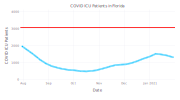

In [329]:
plt = plot(
    layer(
        hhstotal,
        x = :date,
        y = :active_icu,
        Geom.point, Geom.line,
    ),
    layer(
        yintercept = [sum(data.capacity)],
        Geom.hline(color="red", size=0.8mm),
    ),
    Scale.y_continuous(format=:plain),
    Guide.xlabel("Date"),
    Guide.ylabel("COVID ICU Patients"),
    Guide.title("COVID ICU Patients in Florida"),
    style(background_color=colorant"white"),
)
plt |> SVG(18cm, 10cm)
plt |> PNG("metrics_fl/active_patients.png", 18cm, 10cm, dpi=250)

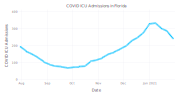

In [328]:
plt = plot(
    hhstotal,
    x = :date,
    y = :admissions_icu,
    Geom.point, Geom.line,
    Guide.xlabel("Date"),
    Guide.ylabel("COVID ICU Admissions"),
    Guide.title("COVID ICU Admissions in Florida"),
    style(background_color=colorant"white"),
)
plt |> SVG(18cm, 10cm)
plt |> PNG("metrics_fl/admitted_patients.png", 18cm, 10cm, dpi=250)